In [1]:
import CHONK_cpp as ch
import numpy as np
import fastscapelib_fortran as fs
import lsdtopytools as lsd
import numba as nb
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output, display

dt = 10
model = ch.ModelRunner( dt, 0, ["drainage_area","move","basic_SPIL"], "MF_fastscapelib") #"D8"
# model.update_int_param("n_rows", 5)




In [2]:
import time as clock

In [3]:
# @nb.njit()
def check_stack(stack):
    checker = np.zeros(stack.shape, dtype = np.int32)
    incr = 0
    for i in stack:
        checker[i] = incr
        incr +=1
    return checker

# @nb.njit()
# def check_rec(stack,rec):
#     checker = np.zeros(stack.shape, dtype = np.int32)
#     isprocessed = np.zeros(stack.shape, dtype = np.int32)
#     it = 0
#     for i in stack[::-1]:
#         trec = rec[i]
#         if(is_processed[i])

#         checker[i] = it
#         it+=1
#         checker[trec] = it
#         it+=1
#         is_processed[i] = True
#         is_processed[trec] = True

        
#     return checker

# @nb.njit()
def baselevel(stack,rec,mrec):
    checker = np.zeros(stack.shape, dtype = np.int32)

    for i in stack[::-1]:
        if i == rec[i]:
            checker[i] = 1
            checker[mrec[i,0]] = 2
#             print(mrec[i])
        
    return checker
# @nb.njit()
def baselevel_2(stack,rec,postsrec,Z):
    checker = np.zeros(stack.shape, dtype = np.int32)

    for i in stack[::-1]:
        if i == rec[i]:
            if rec[i] != postsrec[i]:
                print("node:",Z[i],"rec:",Z[postsrec[i]])
            else:
#                 print("flub")
                pass
                
            checker[i] = 1
            checker[postsrec[i]] = 2
        
    return checker

# @nb.njit()
def try_identify_pits(receivers, elev, stack):
    pits = []
    recapit = []
    for i in range(receivers.shape[0]):
        ispit = False
        for j in range(receivers.shape[1]):
            if(receivers[i,j] == -1 or ispit == True or receivers[i,j] == i):
                continue
                
            if(elev[i]<elev[receivers[i,j] ]):
                pits.append(i)
                recapit.append(receivers[i,j])
                ispit = True
                
    return np.array(pits),np.array(recapit)

# @nb.njit()
def try_identify_pits_single(receivers, elev, stack):
    pits = []
    recapit = []
    for i in range(receivers.shape[0]):

        if(receivers[i] == -1 or receivers[i] == i):
            continue

        if(elev[i]<elev[receivers[i]]):
            pits.append(i)
            recapit.append(receivers[i])


    return np.array(pits),np.array(recapit)
            
# @nb.njit()
def get_delta_elev(receivers, elev, stack):
    pits = []
    for i in range(receivers.shape[0]):
        ispit = False
        for j in range(receivers.shape[1]):
            if(receivers[i,j] == -1 or ispit == True):
                continue
                
            if(elev[i]<elev[receivers[i,j]]):
                pits.append(i)
                ispit = True
                
    return np.array(pits)

# @nb.njit()
def get_acc_from_mstack(mstack, mrec, length, Z):
    checker = np.zeros(mstack.shape[0], dtype = np.int32)

    for node in mstack:

        for j in range(8):
            if(mrec[node,j] < 0):
                continue


            checker[mrec[node,j]] = checker[node] + 1
    

        
    return checker
        
def get_acc_SS_from_mstack(mstack, mrec, length, Z):
    checker = np.zeros(mstack.shape[0], dtype = np.int32)
    new_rec = np.zeros(mstack.shape[0], dtype = np.int32)
    for node in mstack:
        max_slope = -9999
        max_rec = -9999
        for j in range(8):
            if(length[node,j] == 0):
                continue
            this_slope = abs((Z[node] - Z[mrec[node,j]]) / length[node,j])
            
#             print(this_slope)
            if( this_slope > max_slope):
                max_slope = (Z[node] - Z[mrec[node,j]])/length[node,j]
                max_rec = mrec[node,j]
        new_rec[node] = max_rec
    
    for node in mstack:
        checker[new_rec[node]] = checker[node] + 1
    return checker
                    
            
            
            
            

In [4]:
nrows = 100
ncols = 100
xres = 500
yres = 500
xmin = 0
xmax = ncols*yres
ymin = 0
ymax = nrows*xres

# Z = np.load("test_animation/test_animation_0090.npy")
Z = np.random.rand(nrows,ncols)/100
# elev_breaking_stack
# Z = np.load("elev_breaking_stack.npy")

# for j in range(ncols):
#     arr = np.arange(0,round(nrows/2))*1
#     Z[0:round(ncols/2),j] +=arr
#     Z[round(ncols/2):,j] += arr[::-1] 


uplift = np.zeros_like(Z)
uplift[1:-1] = 0.001
# uplift[60:120,:] = 0.001*dt
uplift = uplift.ravel()

fs.fastscape_init()
fs.fastscape_set_nx_ny(ncols,nrows)
fs.fastscape_setup()
fs.fastscape_set_xl_yl(xmax - xmin, ymax - ymin)
fs.fastscape_set_bc(1010)

fstctx = fs.fastscapecontext
fstctx.p = 3
fstctx.h = Z.astype(np.float64).ravel()
fstctx.kf = np.ones_like(fstctx.h) * 1e-3
fstctx.kfsed = 1e-3
fstctx.m = 0.45
fstctx.n = 1.
fstctx.kd = np.ones_like(fstctx.h) * 1e-3
fstctx.kdsed = 1e-3
fstctx.g1 = 1.0
fstctx.g2 = 1.0

fs.fastscape_set_dt(1000)
# fs.flowrouting_first_stack ()
# prestack = np.copy(fstctx.stack.astype('int') - 1)
# prerec = np.copy(fstctx.rec.astype('int') - 1)
# fs.flowrouting_reroute_local_minima ()
# postsrec = np.copy(fstctx.rec.astype('int') - 1)
# poststack = np.copy(fstctx.stack.astype('int') - 1)
# print("Bite")

# fs.fastscape_destroy()

In [5]:
# params to add
# model.update_int_param[] = 
# model.update_double_param[] = 
# model.update_array_int_param[] = 
# model.update_array2d_int_param[] = 
# model.update_array_double_param[] = 
# model.update_array2d_double_param[] = 



# model.update_array_int_param("pre_stack", prestack)
# model.update_array_int_param("pre_rec", prerec)
# model.update_array_int_param("m_stack", mstack)
# model.update_array2d_int_param("m_rec", mrec)
# model.update_array2d_int_param("m_don", mdon)
model.update_array_double_param("surface_elevation", Z.ravel())
# model.update_array2d_double_param("length", lengths)
model.update_double_param("x_min", xmin)
model.update_double_param("y_min", ymin)
model.update_double_param("x_max", xmax)
model.update_double_param("y_max", ymax)
model.update_double_param("x_res", xres)
model.update_double_param("y_res", yres)
model.update_double_param("no_data", -9999)
model.update_int_param("n_rows", nrows)
model.update_int_param("n_cols", ncols)
model.update_int_param("n_elements", nrows*ncols)
model.update_array_double_param("surface_elevation_tp1", np.copy(Z.ravel()))
model.update_array_double_param("sed_height", np.zeros_like(Z.ravel()))
model.update_array_double_param("sed_height_tp1", np.zeros_like(Z.ravel()))
model.update_array_double_param("lake_depth", np.zeros_like(Z.ravel()))

model.update_double_param("SPIL_n", 1)
model.update_double_param("SPIL_m", 0.45)
model.update_array_double_param("erodibility_K", np.zeros_like(Z.ravel())+1e-4)



In [6]:
# print("y")
dt = 30
uplift = uplift.reshape(nrows,ncols)
uplift = np.zeros_like(uplift)
uplift[1:-1,:] = 0.001
# uplift[10:20,:] = 0.005
# uplift[60:80,60:80] = 0
# uplift[50:60,50:60] = -0.2
uplift = uplift.ravel()

this_K = np.zeros_like(Z.ravel()).reshape(nrows,ncols)+1e-4
# this_K[10:20,:] = 1e-5 
this_K = this_K.ravel()
# print("t")
model.update_timestep(dt)
for i in range(1001):
#     if(input()=='b'):
#         break
#     print("f")
#     input("start")
    print("%s||"%i, end = "") if i%10 ==0 else 0
#     S = clock.time() 
    new_elev = model.get_array_double_param("surface_elevation_tp1")
    new_sed = model.get_array_double_param("sed_height_tp1")
    new_elev = new_elev + (uplift * dt)
    new_elev += np.random.rand(new_elev.shape[0])*1e-6

#     print("l")
#     fs.fastscape_init()
#     fs.fastscape_set_nx_ny(ncols,nrows)
#     fs.fastscape_setup()
#     fs.fastscape_set_xl_yl(xmax - xmin, ymax - ymin)
#     fstctx = fs.fastscapecontext
#     checkelev = np.copy(new_elev)
#     print(np.unique(checkelev - new_elev))
    
    fstctx.p = 3
    fstctx.h = new_elev
    # fs.fastscape_init_h(raster["array"].astype(np.float64).ravel())
#     print("p")
    fstctx.kf = np.ones_like(fstctx.h) * 1e-3
    fstctx.kfsed = 1e-3
    fstctx.m = 0.45
    fstctx.n = 1.
    fstctx.kd = np.ones_like(fstctx.h) * 1e-3
    fstctx.kdsed = 1e-3
    fstctx.g1 = 1.0
    fstctx.g2 = 1.0
#     fs.fastscape_set_bc(1010)

#     fstctx.ibc = 1111
#     fs.fastscape_set_dt(1000)
#     input("before stack")
#     print("1")
    fs.find_stacks_with_intermediate_save ()
#     input("after stack")

#     print("2")
    prestack = np.copy(fstctx.stack0.astype('int') - 1)
    prerec = np.copy(fstctx.rec0.astype('int') - 1)

    postsrec = np.copy(fstctx.rec.astype('int') - 1)
    poststack = np.copy(fstctx.stack.astype('int') - 1)
    mdon = np.copy(fstctx.don.astype('int').transpose() - 1)
    mstack = np.copy(fstctx.mstack.astype('int') - 1)
    mrec = np.copy(fstctx.mrec.astype('int').transpose() - 1)
    lengths = np.copy(fstctx.mlrec.transpose())
    weights = np.copy(fstctx.mwrec.transpose())
    
    tmrec = np.copy(mrec)
    tmstack = np.copy(mstack)
    ttmrec = np.copy(tmrec)
#     fs.fastscape_destroy()
#     print("u")
#     print(np.unique(checkelev - new_elev))


    model.update_array_int_param("pre_stack", prestack)
    model.update_array_int_param("pre_rec", prerec)
    model.update_array_int_param("post_rec", postsrec)    
    model.update_array_int_param("post_stack", poststack)
    model.update_array_int_param("m_stack", mstack)
    model.update_array2d_int_param("m_rec", mrec)
    model.update_array2d_int_param("m_don", mdon)
    model.update_array2d_double_param("length", lengths)
    model.update_array2d_double_param("external_weigths_water", weights)
#     model.update_array_int_param("depression_to_reroute", pit_to_process)


    model.update_array_double_param("surface_elevation", np.copy(new_elev))
    model.update_array_double_param("surface_elevation_tp1", np.copy(new_elev))
#     model.update_array_double_param("sed_height", np.zeros_like(new_sed.ravel()))
    model.update_array_double_param("sed_height", np.copy(new_sed))
    model.update_array_double_param("sed_height_tp1", np.copy(new_sed))
#     model.update_array_double_param("lake_depth", model.get_other_attribute("lake_depth"))

    model.update_array_double_param("erodibility_K", this_K)
    model.update_double_param("SPIL_n", 1)
    model.update_double_param("SPIL_m", 0.45)
#     print(fstctx.bounds_ibc, "||", fstctx.bounds_ycyclic, "||",fstctx.bounds_xcyclic )
# # 
    
# #     print("r")
# #     model.DEBUG_check_weird_val_stacks()    
#     print("Fs-bit took ", clock.time() - S)
    S = clock.time()
#     input("before graph")
#     print("1")
    model.initiate_nodegraph()
#     print("init_nodegraph-bit took ", clock.time() - S)
    S = clock.time()

    #     print("2")
#     print("b")
#     input("after graph")
    model.run()
#     print("run-bit took ", clock.time() - S)
    S = clock.time()
    
#     print("3")
    
#     input("after run")
#     print(np.min(model.get_array_double_param("surface_elevation_tp1")))
    if(np.min(model.get_array_double_param("surface_elevation_tp1")) == np.nan):
        print("BAGULLE")

    if(i%10==0):
        name = str(i)
        while(len(name)<4):
           name = "0" + name
        np.save("test_animation/test_animation_%s.npy"%(name), new_elev)
        np.save("test_animation/test_animation_%s_lake.npy"%(name),  model.get_other_attribute("lake_depth"))
                


    

0||10||20||30||40||50||60||70||80||90||100||110||120||130||140||150||160||170||180||

KeyboardInterrupt: 

In [ ]:


# # model.DEBUG_modify_double_array_param_inplace("surface_elevation_tp1", 50210, 70000)
Zp1 = model.get_array_double_param("surface_elevation_tp1")
print(np.min(Zp1))

fig,ax = plt.subplots(figsize = (10,10))

# cb = ax.imshow(Z.reshape(raster["nrows"],raster["ncols"])- Zp1.reshape(raster["nrows"],raster["ncols"]), 
#      cmap = "viridis")
# model.get_water_flux()
noerr = np.copy(Zp1.reshape(nrows,ncols))
noerr[noerr>0] = np.nan
 
cb = ax.imshow(Zp1.reshape(nrows,ncols), vmin = 0, cmap = "gray", extent = [xmin,xmax,ymin,ymax])
lake = model.get_array_double_param("lake_depth").reshape(nrows,ncols)
lake[lake<=0] = np.nan
ax.imshow(lake,vmin =-5, vmax = -4, cmap = "Blues", extent = [xmin,xmax,ymin,ymax])
# cb = ax.imshow((Zp1 - tempsave).reshape(nrows,ncols), vmin = 0, cmap = "gist_earth", extent = [xmin,xmax,ymin,ymax])
# cb = ax.imshow(model.get_other_attribute("lake_depth").reshape(nrows,ncols), vmin = 0,     cmap = "viridis")
# cb = ax.imshow(np.log10(model.get_water_flux().reshape(nrows,ncols)), vmin = 3, cmap = "Blues")
# cb = ax.imshow(model.get_erosion_flux().reshape(nrows,ncols), cmap = "viridis")
# cb = ax.imshow(model.get_sediment_flux().reshape(nrows,ncols), cmap = "viridis")

# cb = ax.imshow(model.get_all_nodes_in_depression().reshape(nrows,ncols), cmap = "viridis")
# cb = ax.imshow(model.DEBUG_get_preacc().reshape(nrows,ncols), cmap = "viridis")
# cb = ax.imshow(model.get_array_double_param("sed_height_tp1").reshape(nrows,ncols), cmap = "viridis")


# cb = ax.imshow(Z.reshape(raster["nrows"],raster["ncols"])[600:700,400:500] - Zp1.reshape(raster["nrows"],raster["ncols"])[600:700,400:500], 
#     vmin = -0.1,vmax = 0.5, cmap = "viridis")
# cb = ax.imshow(Z.reshape(raster["nrows"],raster["ncols"])[550:650,400:500], cmap = "viridis",vmin = 500, vmax = 800 )
plt.colorbar(cb, label = r"Erosion rates $(mm.yrs^{-1})$")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

# plt.savefig("errate.png",dpi = 600 )

In [8]:
# print(np.unique(model.get_other_attribute("lake_depth")))
# tempsave = np.copy(Zp1)
# print(model.get_array_int_param("m_stack"))
# print(model.get_int_param("n_elements"))

# # print(old_elev[model.get_array2d_int_param("m_rec")[1909]] - old_elev[2010])
# # print(old_elev[mrec[1075]] - old_elev[1075])
# print(tmrec[8805])
# print(prerec[5818])
# print(model.get_array_int_param("m_stack")[5956]
# print(model.get_array_int_param("post_rec")[5956])
# print(np.argwhere(model.get_array_int_param("m_stack") == 5956))
     
# print(model.DEBUG_get_basin_label()[11467])
# # node = model.DEBUG_get_graph_rec()[5956][0]
# # while(len(model.DEBUG_get_graph_rec()[node])>0):
# #     print(model.DEBUG_get_graph_rec()[node], end = "||")
# #     node = model.DEBUG_get_graph_rec()[node][0]
elevation = model.get_array_double_param("surface_elevation")
# graph = model.DEBUG_get_graph_rec()
# node2alias = model.DEBUG_get_node_to_aliases()
# alias2node = {}
# for key,val in node2alias.items():
#     for v in val:
#         alias2node[v] = key
# for i in range(len(graph)):
#     if(4398 in graph[i]):
#         print(i, end = "||")
# print()
# print(graph[1222])
# print(alias2node[12581])
# print(graph[4399])
# print(graph[4299])

print(ttmrec[1815])
print(model.get_array2d_int_param("m_don")[1815])
print(elevation[model.get_array2d_int_param("m_don")[1815]] - elevation [1815])
# print(elevation[4299])
# print(elevation[4399])
# print(graph[4399])
# print(ttmrec[100])
# print(elevation[100])
# print(elevation[ttmrec[100]])
# print(ttmrec[4399])
# print(alias2node[11096])
# print(elevation[4399]>elevation[4300] )
# for i in range(ttmrec.shape[0]):
#     for rec in ttmrec[i]:
#         if(rec == -1):
#             continue
#         if(elevation[i]<elevation[rec]):
#             print("ERROR::",i,"||",rec)



# print(np.unique(np.unique(model.get_array_int_param("m_stack"),return_counts = True)[1]))
# print(tmstack[4732])
# print(model.get_array_int_param("m_stack")[4732])
# print(model.get_array2d_int_param("m_rec")[5653])
# print(model.get_array2d_double_param("external_weigths_water")[5421])

[1814   -1   -1   -1   -1   -1   -1   -1]
[1714 1715 1716 1816 1914 1915 1916   -1]
[0.00495665 0.00563606 0.00095577 0.00262013 0.00608132 0.00796761
 0.00794361 0.00213086]


In [9]:
length = np.copy(fstctx.length)

popup_elev = ch.pop_elevation_to_SS_SF_SPIL(poststack, postsrec,length , uplift, this_K, 0.9, 0.45, xres*yres)
pZ = np.copy(popup_elev)
# del popup_elev
# fig,ax = plt.subplots()
# cb = ax.imshow(pZ.reshape(nrows,ncols), cmap = "gray")


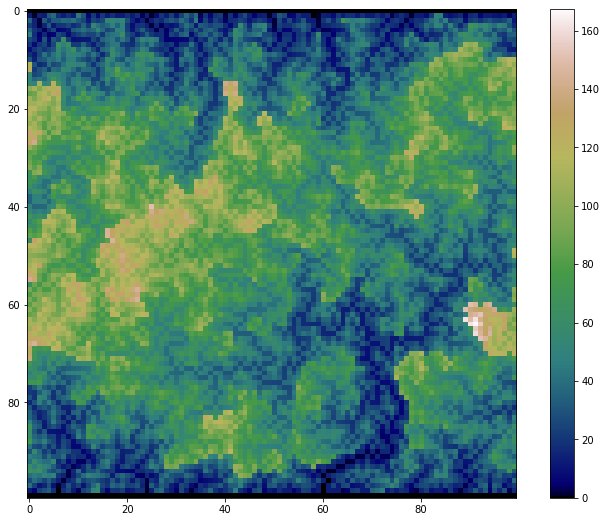

In [10]:
pZ = pZ.reshape(nrows,ncols)
fig,ax = plt.subplots(figsize = (12,9))
cb = ax.imshow(pZ, cmap = "gist_earth")
plt.colorbar(cb)

In [11]:
from  scipy.ndimage import gaussian_filter as gaussian

pZ = gaussian(pZ, 3, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)



In [12]:
model.update_array_double_param("surface_elevation_tp1",pZ.ravel())

In [8]:
new_elev = model.get_array_double_param("surface_elevation_tp1")
old_elev = model.get_array_double_param("surface_elevation")
print(np.median(new_elev - old_elev)/dt)
# print(np.median(model.get_erosion_flux()))
lsd.raster_loader.save_raster((old_elev+model.get_array_double_param("lake_depth")).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","random1_topolake.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster(old_elev.reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","random1.tif", fmt = 'GTIFF')

lsd.raster_loader.save_raster(np.log10(model.get_water_flux().reshape(nrows,ncols)),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","random1_DA.tif", fmt = 'GTIFF')

lsd.raster_loader.save_raster(check_stack(model.get_array_int_param("m_stack")).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","randomcheckstack.tif", fmt = 'GTIFF')

lsd.raster_loader.save_raster(check_stack(model.get_array_int_param("post_stack")).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","randomcheckpoststack.tif", fmt = 'GTIFF')

lsd.raster_loader.save_raster(check_stack(model.get_array_int_param("pre_stack")).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","randomcheckprestack.tif", fmt = 'GTIFF')


lsd.raster_loader.save_raster(model.get_array_double_param("lake_depth").reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","random1_lake.tif", fmt = 'GTIFF')


# lsd.raster_loader.save_raster( CHECK_POSTREC.astype(np.int32).reshape(nrows,ncols),
#    0,xres*ncols,yres*nrows,0,xres,"epsg:32635","random1prerec_order.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster( model.get_array_int_param("pre_rec").reshape(nrows,ncols).astype(np.int32).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","random1preprerec_order.tif", fmt = 'GTIFF')

# dep = model.get_all_nodes_in_depression().reshape(nrows,ncols)
# lsd.raster_loader.save_raster(dep,
#    0,xres*ncols,yres*nrows,0,xres,"epsg:32635","random1_dep.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster(baselevel_2(model.get_array_int_param("pre_stack"),
                                          model.get_array_int_param("pre_rec"),
                                          model.get_array_int_param("post_rec"),old_elev).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","random1node.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster( model.get_array_int_param("post_rec").reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","random1rec_order.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster(np.arange(nrows*ncols, dtype = np.int32).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","random1nodeID.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster(get_acc_from_mstack(model.get_array_int_param("m_stack"), 
                       model.get_array2d_int_param("m_rec"), 
                       model.get_array2d_double_param("length"), 
                       old_elev.ravel()).reshape(nrows,ncols),0,xres*ncols,yres*nrows,0,xres,"epsg:32635","random1acc_mstack.tif", fmt = 'GTIFF')


-0.000637234131474429
node: 66.95494999263153 rec: 66.97062110747214


In [36]:
# new_elev = model.get_array_double_param("surface_elevation")
# np.save("elev_breaking_stack.npy",new_elev)

In [ ]:
model.update_array_double_param("surface_elevation_tp1",model.get_array_double_param("surface_elevation"))

In [ ]:
print(10**4.2 + 10**4.2)

In [ ]:
import hvplot.xarray  # noqa
import holoviews as hv
import xarray as xr
hv.extension('matplotlib')

arrs = []
lakes = []
for i in range(1001):
    if(i%10 != 0):
        continue
        
    name = str(i)
    while(len(name)<4):
       name = "0" + name
    arrs.append( np.load("test_animation/test_animation_%s.npy"%(name)).reshape(nrows,ncols) )
    A = np.load("test_animation/test_animation_%s_lake.npy"%(name)).reshape(nrows,ncols)
    A[A<=0] = np.nan
    lakes.append(A)

xdim = np.arange(xmin,xmax,xres)
ydim = np.arange(ymin,ymax,yres)

arrs = xr.DataArray(arrs, dims = ['out', "y", "x"], 
    coords = {"x":xdim , "y": ydim,
              "out": np.arange(len(arrs))})
lakes = xr.DataArray(lakes, dims = ['out', "y", "x"], 
    coords = {"x":xdim , "y": ydim,
              "out": np.arange(len(arrs))})


topo = arrs.hvplot.image(x='x', y='y', 
    width=1200, height=1200,#ylim = (0.5e5,2e5),
    cmap=plt.cm.gray, groupby='out', dynamic = False
)
lake = lakes.hvplot.image(x='x', y='y', clim = (-5,-4),
    width=1200, height=1200,#ylim = (0.5e5,2e5),
    cmap=plt.cm.Blues_r, groupby='out', dynamic = False
)


   

In [ ]:
hv.save(topo * lake, 'test2_MultipleFlow_100_lake.mp4', fps=5, dpi = 600)

In [ ]:
np.sum(weights[5487])

In [ ]:
print(mrec[0])

In [ ]:
np.median(model.get_erosion_flux().reshape(nrows,ncols))

In [ ]:
plt.imshow(uplift.reshape(nrows,ncols)[0:5])

In [ ]:
#raster name putna_50_NDF
raster = lsd.raster_loader.load_raster("putna_50_NDF.tif")

In [ ]:
stack = fstctx.mstack.astype('int') - 1
nb_receivers = fstctx.mnrec.astype('int')
receivers = fstctx.mrec.astype('int').transpose() - 1
lengths = fstctx.mlrec.transpose()
weights = fstctx.mwrec.transpose()

sstack = fstctx.stack.astype('int') - 1
sreceivers = fstctx.rec.astype('int') - 1

In [ ]:
receivers[5300]

In [ ]:
# fstctx.mstack.astype("int")
checker = check_stack(stack)
checker = checker.reshape(raster["nrows"],raster["ncols"])
pits, recapit = try_identify_pits(receivers, raster["array"].astype(np.float32).ravel(), stack)
# pits, recapit = try_identify_pits_single(sreceivers, raster["array"].astype(np.float32).ravel(), sstack)

fig,ax = plt.subplots(figsize = (10,12))
cb = ax.imshow(raster["array"][500: 520, 695:715 ], cmap = "gray", vmin = 300, vmax = 400)
cb =ax.imshow(checker[500: 520,695:715 ], alpha=1, cmap = "magma")
# cb =ax.imshow(nb_receivers.reshape(raster["nrows"],raster["ncols"]), alpha=1, cmap = "magma")
colspit = pits % raster["ncols"]
rowspit = ((pits - colspit)/ raster["ncols"]).astype(np.int32)

rcolspit = recapit % raster["ncols"]
rrowspit = ((recapit - rcolspit)/ raster["ncols"]).astype(np.int32)

# ax.scatter(colspit, rowspit, lw = 0, c = "yellow")
# ax.scatter(rcolspit, rrowspit, lw = 0, c = "green")

# ax.set_xlim(695,715)
# ax.set_ylim(520, 500)

print(receivers[0])
print(stack.shape)

plt.colorbar(cb)

In [ ]:
cols = stack % raster["ncols"]
rows = ((stack - cols)/ raster["ncols"]).astype(np.int32)
import lsdtopytools as lsd
mydem = lsd.LSDDEM(file_name ="putna_50_NDF.tif", already_preprocessed = True )
X,Y = mydem.cppdem.query_xy_from_rowcol(rows,cols)
import pandas as pd
pd.DataFrame({"incr": checker.ravel(), "X": X, "Y":Y}).to_csv("checker.csv", index = False)

In [ ]:
bite =  np.zeros(fstctx.nn)
bc =  np.zeros(fstctx.nn)

dx = fstctx.xl/(fstctx.nx - 1)
dy = fstctx.yl/(fstctx.ny - 1)
i1 = np.int32(0)
i2 = np.int32(0)
j1 = np.int32(0)
j2 = np.int32(0)
xcyclic = np.bool(0)
ycyclic = np.bool(0)

fs.set_bc(fstctx.ibc, fstctx.nx, fstctx.ny) #, i1, i2, j1, j2, bc, xcyclic, ycyclic)
fs.find_receiver(fstctx.h,fstctx.nx,fstctx.ny,dx,dy,i1,i2,j1,j2,xcyclic, ycyclic)


In [ ]:

@nb.njit()
def check_stack(stack):
    checker = np.zeros(stack.shape, dtype = np.int32)
    incr = 0
    for i in stack:
        checker[i] = incr
        incr +=1
    return checker

@nb.njit()
def try_identify_pits(receivers, elev, stack):
    pits = []
    recapit = []
    for i in range(receivers.shape[0]):
        ispit = False
        for j in range(receivers.shape[1]):
            if(receivers[i,j] == -1 or ispit == True or receivers[i,j] == i):
                continue
                
            if(elev[i]<elev[receivers[i,j] ]):
                pits.append(i)
                recapit.append(receivers[i,j])
                ispit = True
                
    return np.array(pits),np.array(recapit)

@nb.njit()
def try_identify_pits_single(receivers, elev, stack):
    pits = []
    recapit = []
    for i in range(receivers.shape[0]):

        if(receivers[i] == -1 or receivers[i] == i):
            continue

        if(elev[i]<elev[receivers[i]]):
            pits.append(i)
            recapit.append(receivers[i])


    return np.array(pits),np.array(recapit)
            
@nb.njit()
def get_delta_elev(receivers, elev, stack):
    pits = []
    for i in range(receivers.shape[0]):
        ispit = False
        for j in range(receivers.shape[1]):
            if(receivers[i,j] == -1 or ispit == True):
                continue
                
            if(elev[i]<elev[receivers[i,j]]):
                pits.append(i)
                ispit = True
                
    return np.array(pits)
            

In [ ]:
fs.fastscape_destroy()